In [48]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore
import gzip
import os
import csv
from alive_progress import alive_bar
from collections import defaultdict
import time


In [49]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col, element_at, slice, size, regexp_extract, transform, when, explode, \
monotonically_increasing_id, map_from_arrays, lit, udf,collect_list, row_number, ceil, map_keys, expr, from_json
from pyspark.sql.types import ShortType, ArrayType, LongType, StringType
from pyspark.sql import types as T

import pandas as pd

#path = 'C:/Users/bincl/BA-Thesis/Dataset/2gram/2_20000_nopos_ab.gz'
start_date = 1800
end_date = 2000
directory_3gram = 'C:/Users/bincl/BA-Thesis/Dataset/2gram/parquet/'
directory_2gram = 'C:/Users/bincl/BA-Thesis/Dataset/1gram/parquet/'

spark = SparkSession.builder.appName('3gramSQL').getOrCreate()

df_3gram = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(directory_3gram)      

In [50]:

df_2gram = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(directory_2gram)      

In [51]:
df_3gram.head(10)


[Row(Tokens='derartige Beachtung', Data={'1855': 2, '1976': 1, '1975': 3, '1974': 13, '1973': 5, '1972': 2, '1850': 2, '1971': 8, '1970': 2, '1979': 4, '1978': 3, '1977': 3, '1908': 6, '1987': 1, '1865': 6, '1986': 6, '1985': 3, '1984': 4, '1983': 4, '1982': 4, '1860': 1, '1981': 3, '1980': 4, '1907': 10, '1906': 6, '1905': 8, '1904': 2, '1903': 6, '1902': 9, '1868': 1, '1901': 2, '1900': 4, '1988': 4, '1919': 3, '1880': 1, '1910': 1, '1998': 6, '1997': 3, '1875': 3, '1996': 3, '1995': 7, '1994': 3, '1993': 3, '1871': 1, '1992': 3, '1991': 5, '1917': 1, '1916': 5, '1915': 6, '1913': 3, '1912': 4, '1878': 1, '1999': 2, '1891': 4, '1921': 4, '1920': 7, '1886': 2, '1885': 2, '1884': 1, '1882': 1, '1929': 1, '1928': 1, '1927': 4, '1926': 1, '1925': 1, '1924': 1, '1922': 7, '1899': 4, '1931': 3, '1897': 1, '1930': 2, '1896': 4, '1895': 2, '1893': 1, '1939': 1, '1938': 1, '1937': 3, '1935': 4, '1933': 1, '2001': 4, '2000': 5, '1943': 1, '1949': 4, '1948': 3, '2012': 3, '2011': 4, '2010': 5, 

In [52]:
df_2gram.head(10)

[Row(Tokens='kontinuierlichen', Data={'1696': 1, '1695': 1, '1909': 8247, '1908': 9717, '1907': 8632, '1906': 8948, '1905': 7227, '1904': 6482, '1903': 4993, '1902': 2436, '1901': 2180, '1900': 2674, '1919': 4823, '1910': 9107, '1918': 3492, '1917': 4132, '1916': 4691, '1915': 6199, '1914': 9235, '1913': 10150, '1912': 9543, '1911': 9687, '1809': 1, '1800': 2, '1921': 6189, '1920': 5489, '1808': 2, '1929': 5052, '1807': 2, '1928': 5819, '1927': 4880, '1805': 5, '1926': 4415, '1804': 1, '1925': 3734, '1803': 4, '1924': 3004, '1923': 3625, '1801': 2, '1922': 7042, '1811': 6, '1932': 4471, '1810': 3, '1931': 4973, '1930': 5211, '1818': 1, '1939': 2569, '1938': 4024, '1816': 1, '1937': 3772, '1936': 3017, '1935': 3390, '1813': 6, '1934': 3441, '1812': 10, '1933': 4424, '2001': 13918, '2000': 12845, '1943': 1792, '1942': 1548, '1820': 2, '1941': 1711, '1940': 2118, '1829': 8, '1828': 1, '1949': 2459, '1948': 2236, '1705': 1, '1826': 6, '1947': 1551, '1946': 748, '1703': 1, '1824': 1, '1945'

In [53]:
# if id set as default parameter then a list is given if not a spark dataframe is given as parameter df
def get_pd_df(df):
    matched = df['Data'] 
    matched_pandas_df = pd.Series(matched)
    matched_pandas_df.sort_index(inplace = True)

    matched_pandas_df.index.astype('int')
    numbers = list(range(start_date,end_date))
    numbers = map(str, numbers)
    matched_pandas_df = matched_pandas_df.reindex(numbers, fill_value= 0)
    return matched_pandas_df

def get_pd_df_from_string(suchstring, df):
    x = df.select(['Tokens', 'Data']).where(df.Tokens == suchstring)
    print(suchstring)
    print(x.first())
    matched = x.first()['Data']
    matched_pandas_df = pd.Series(matched)
    matched_pandas_df.sort_index(inplace = True)

    matched_pandas_df.index.astype('int')
    numbers = list(range(start_date,end_date))
    numbers = map(str, numbers)
    matched_pandas_df = matched_pandas_df.reindex(numbers, fill_value= 0)
    return matched_pandas_df

In [54]:
# deprecated zu langsam
def find_n_gram(direc, find):
    for filename in os.listdir(direc):
        f = os.path.join(direc, filename)
        # checking if it is a file
        if os.path.isfile(f):
            with gzip.open(f,'rt', encoding='utf-8') as input:
                str_arr_csv = input.readlines()
                for line in str_arr_csv:
                    token = line.split("\t")
                    if find == token[0]:
                        return line
                        
    return "line not found" 

def start_the_search(directory,search):
    result = find_n_gram(directory,search)
    
    if result == "line not found":
        print(result)
        exit()
    result = result.split("\t")
    lower_ngram = pd.Series(result[1:],dtype= "string", name = result[0])
    return lower_ngram

In [55]:
def getLowerLevelString(string):
   first, *middle, last = string.split()
   if len(middle) != 0:
        first = first + " " + ''.join(middle)
        last = ''.join(middle) + " " + last    
   return first, last

def MLR(token,data):
    y = data
    first,last = getLowerLevelString(token)
    first = get_pd_df_from_string(first,df_2gram)
    last = get_pd_df_from_string(last,df_2gram)
    X = pd.concat([first,last],axis=1)
    reg = LinearRegression()
    reg.fit(X, y) 
    return reg.coef_,reg.intercept_,X,y

def buildApproximation(c1,c2,basevalue,df):
    df = df.astype('float')
    
    df = df.fillna(0)
    
    df['scaledFirst'] = df.iloc[:,0].apply(lambda x: x * c1) 
    df['scaledLast'] = df.iloc[:,1].apply(lambda x: x * c2) 
    df['approximation'] = df['scaledFirst'] + df['scaledLast'] + basevalue
    return df

In [56]:
def compressWithError2gram(n,error):
    df_3_gram = df_3gram.head(n)
    result = []
    all = []
    sum = []
    firstN = range(0,n)
    
    with alive_bar(len(firstN), force_tty = True, bar = 'smooth') as bar:
        for i in firstN:
            df_file = df_3_gram[i]
            data = get_pd_df(df_file)
            token = df_file['Tokens']
            if not(data.eq(0).all()):
                coef,intercept,dfAprox,original = MLR(token,data)
                c1,c2 = coef
                df = buildApproximation(c1,c2,intercept,dfAprox)
                dfOriginal = pd.DataFrame()
                dfOriginal['values'] = original
                dfOriginal['values'] = dfOriginal['values'].apply(pd.to_numeric, errors='coerce')
                #dfOriginal= pd.to_numeric(dfOriginal)
                dfOriginal['zscore'] = zscore(dfOriginal)
                df['zscore'] = zscore(df['approximation'])
                sum.append(df_file['Sum']) 
                rmse = mean_squared_error(dfOriginal['zscore'], df['zscore'], squared = False)
                #rmse = mean_squared_error(dfOriginal, df['approximation'])
                if rmse <= error:
                    result.append([token,rmse,dfOriginal['values'],dfOriginal['zscore'],df['approximation'],df['zscore']]) 
                all.append(rmse)    
            bar()
    return result, all, sum


In [57]:
result, all, sum = compressWithError2gram(100, 1)
print(sum)
print(all)
print(len(result))

on 0: derartige                                                                 
on 0: None                                                                      
|⚠︎                                       | (!) 0/100 [0%] in 0.4s (0.00/s)      


TypeError: 'NoneType' object is not subscriptable

In [59]:
x = get_pd_df_from_string("derartige", df_2gram)
print(x)

derartige
Row(Tokens='derartige', Data={'1698': 1, '1697': 10, '1909': 122346, '1908': 138241, '1588': 1, '1584': 4, '1907': 129011, '1906': 133402, '1905': 120352, '1904': 117422, '1903': 106149, '1902': 106530, '1901': 98011, '1900': 90476, '1919': 55206, '1910': 117739, '1918': 56279, '1917': 57087, '1916': 62762, '1915': 69143, '1914': 115725, '1913': 132290, '1912': 126012, '1911': 127962, '1809': 71, '1492': 3, '1800': 87, '1921': 68543, '1920': 62874, '1808': 54, '1929': 46590, '1807': 50, '1928': 48044, '1806': 8, '1927': 44210, '1805': 45, '1926': 42919, '1804': 48, '1925': 41333, '1803': 10, '1924': 29274, '1802': 14, '1923': 36019, '1801': 15, '1922': 69741, '1811': 52, '1932': 39577, '1810': 10, '1931': 44126, '1930': 48231, '1819': 96, '1818': 117, '1939': 29666, '1817': 34, '1938': 31591, '1816': 10, '1937': 33198, '1815': 6, '1936': 31935, '1814': 7, '1935': 33831, '1813': 33, '1934': 33896, '1812': 5, '1933': 36596, '2001': 54768, '2000': 53318, '1822': 157, '1943': 161

In [ ]:
import pickle
import pandas as pd



# Saving the objects:
with open('rsults_3gram_1000.pkl', 'wb') as f:  
    pickle.dump([result, all, sum], f)

# Getting back the objects:



In [ ]:
with open('rsults_3gram_1000.pkl', 'rb') as f:  
    obj = pickle.load(f)
    f.close()
print(obj)   

[[['den Sektor der', 0.13190010162194585, 1800      0
1801      0
1802      0
1803      0
1804      0
       ... 
1995    123
1996    121
1997    125
1998    157
1999    187
Name: values, Length: 200, dtype: int64, 1800   -0.569273
1801   -0.569273
1802   -0.569273
1803   -0.569273
1804   -0.569273
          ...   
1995    0.963242
1996    0.938323
1997    0.988161
1998    1.386864
1999    1.760648
Name: zscore, Length: 200, dtype: float64, 1800     -1.734890
1801     -1.906378
1802     -1.906378
1803     -1.906378
1804     -1.820634
           ...    
1995    154.013317
1996    136.506389
1997    136.417620
1998    145.656943
1999    159.529538
Name: approximation, Length: 200, dtype: float64, 1800   -0.596074
1801   -0.598230
1802   -0.598230
1803   -0.598230
1804   -0.597152
          ...   
1995    1.361495
1996    1.141454
1997    1.140338
1998    1.256465
1999    1.430827
Name: zscore, Length: 200, dtype: float64], ['Erkenntnisse und Methoden', 0.28028285312358703, 1800      0
18

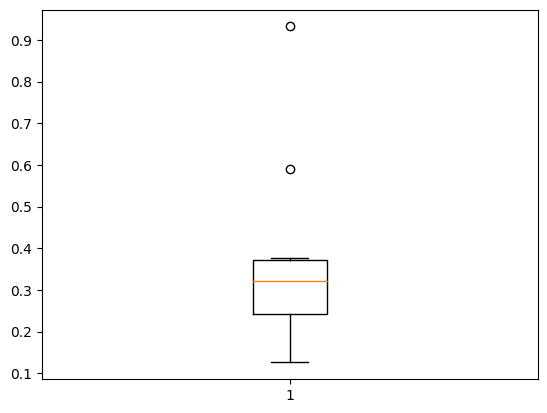

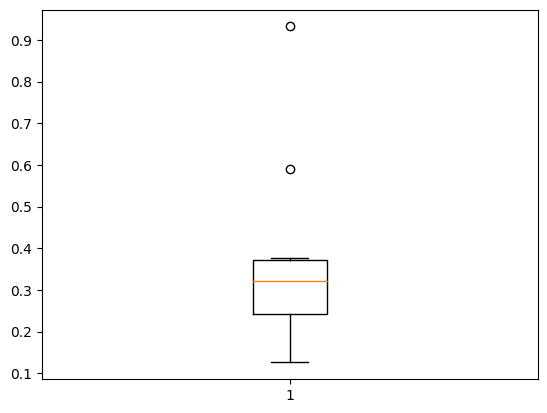

<AxesSubplot: >

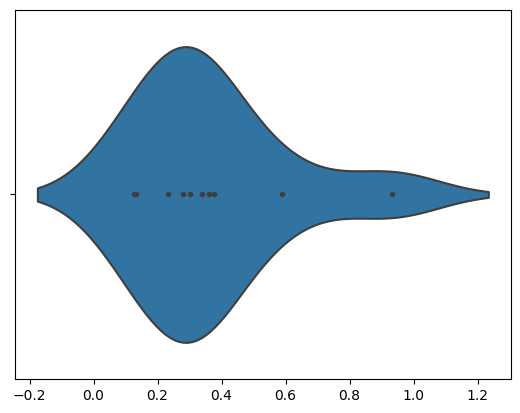

In [ ]:
plt.boxplot(all)
plt.show()
rmse_with_error = []

for i in result:
    rmse_with_error.append(i[1])
plt.boxplot(rmse_with_error)
plt.show()

import seaborn as sns

sns.violinplot(x= rmse_with_error, inner="point")

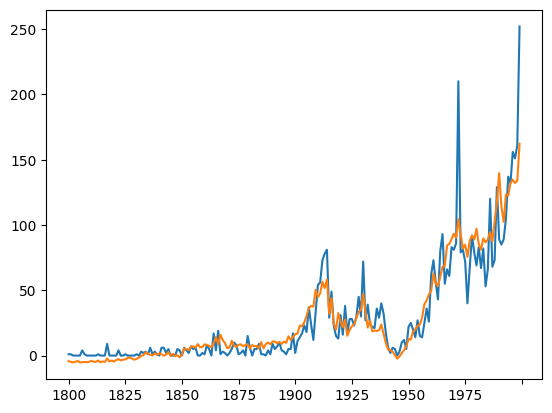

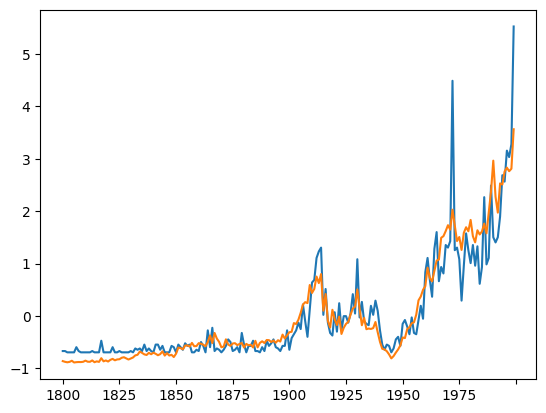

Der Markt der
0.3764926449868947


In [ ]:
n = 3
result[n][2].plot()
result[n][4].plot()
plt.show()
result[n][3].plot()
result[n][5].plot()
plt.show()
print(result[n][0])
print(result[n][1])


<AxesSubplot: >

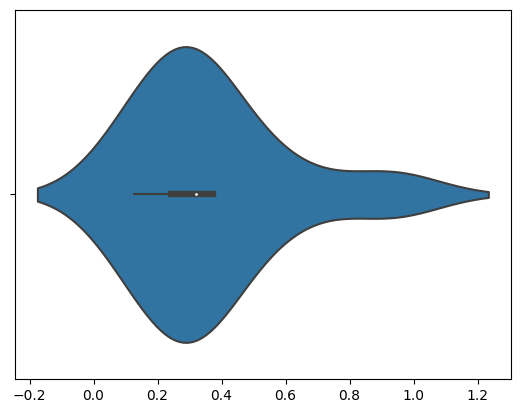

In [ ]:
sns.violinplot(x= all, inner_kws=dict(box_width=15, whis_width=2, color=".8"))

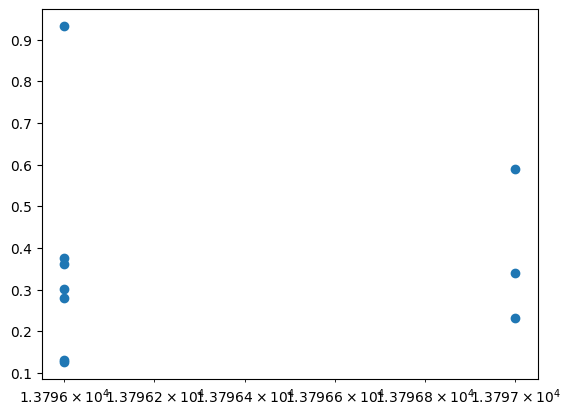

In [ ]:

plt.scatter(sum, all)
plt.xscale('log')
plt.show()